In [1]:
import time
import copy
from collections import defaultdict

import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from skimage import io

from skimage.feature import ORB
from skimage.color import rgb2gray

from skimage.feature import match_descriptors
from skimage.transform import ProjectiveTransform, AffineTransform
from skimage.measure import ransac

from skimage.feature import plot_matches

import cv2

import gtsam
# from gtsam.examples import SFMdata
from gtsam.gtsam import NonlinearFactorGraph
from gtsam.gtsam import Cal3_S2, Point2, Point3, Pose3
from gtsam.gtsam import PriorFactorCal3_S2, PriorFactorPoint3, PriorFactorPose3 
from gtsam.gtsam import GenericProjectionFactorCal3_S2, Rot3, Values
from gtsam.gtsam import LevenbergMarquardtOptimizer

### CV-course path:

In [2]:
FIGSIZE = (15, 10)
NUM_IMAGES = 7
COLUMNS = 3
ROWS = NUM_IMAGES // 3

def plot_collage(imgs, columns=COLUMNS, rows=ROWS, figsize=FIGSIZE, title=None):
    fig = plt.figure(figsize=figsize)
    if title is not None:
        plt.title(title)
        plt.axis('off')
    
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i-1], interpolation='nearest')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

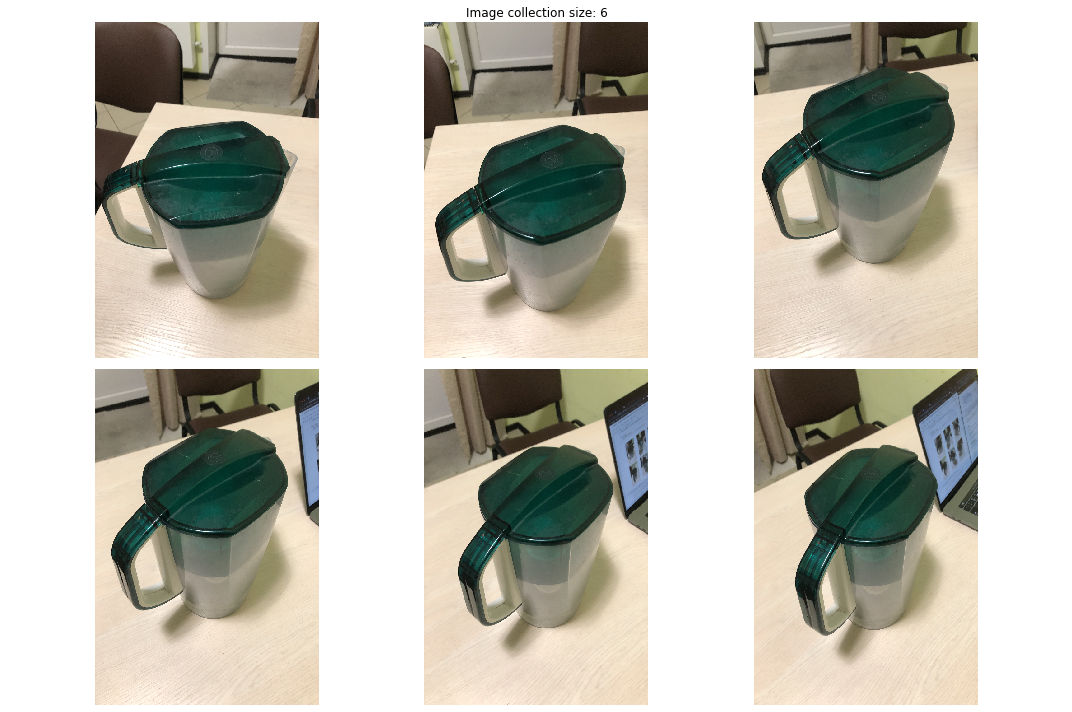

In [3]:
IMAGES_DIR = '/home/ilyazaharkin/ilya_test_kettle/'
TARGET_SIZE = (720, 1080)

pano_image_collection = io.ImageCollection(
    f'{IMAGES_DIR}/*.jpg',
    load_func=lambda f: cv2.resize(io.imread(f), TARGET_SIZE).astype(np.float32) / 255
)

plot_collage(
    pano_image_collection, 
    title=f"Image collection size: {len(pano_image_collection)}"
)

In [4]:
def find_orb(img, n_keypoints=2000, **args):
    """Найти ключевые точки и их дескрипторы на изображении.
    
    img (np.array WxHx3) трехканальное изображение
    n_keypoints (int) число ключевых точек, которые нужно найти на изображении
    **kwargs (dict) остальные параметры, передаются в ORB без изменений
    
    Return: tuple (2,) координаты и дескриторы ключевых точек
    """
    detector_exctractor = ORB(n_keypoints=n_keypoints, **args)
    detector_exctractor.detect_and_extract(rgb2gray(img).astype(np.float64))
    return detector_exctractor.keypoints, detector_exctractor.descriptors

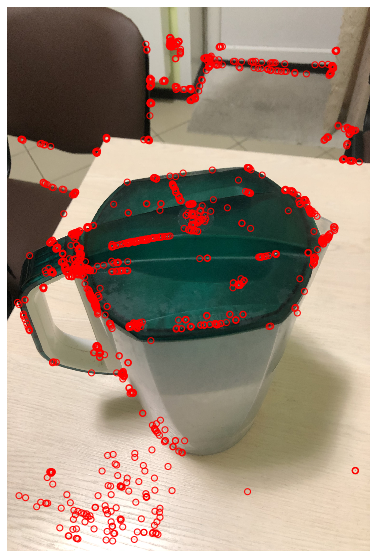

In [5]:
img = pano_image_collection[0]
plt.figure(figsize=FIGSIZE)
plt.imshow(img)
plt.axis('off')

keypoints, descriptors = find_orb(img)

plt.scatter(keypoints[:, 1], keypoints[:, 0], facecolors='none', edgecolors='r');

In [6]:
DEFAULT_TRANSFORM = AffineTransform

def find_robust_transform(
    src_keypoints, src_descriptors, dest_keypoints, dest_descriptors,
    return_matches=False,
    model_class=DEFAULT_TRANSFORM, 
    min_samples=4, 
    residual_threshold=1, 
    max_trials=5000, 
    **kwargs
):
    """Найти соответствие между двумя кадрами панорамы.
    
    src_keypoints, dest_keypoints - координаты ключевых точек
    src_descriptors, dest_descriptors - дескрипторы ключевых точек
    model_class, min_samples, residual_threshold, **kwargs - параметры алгоритма ransac
     - model_class - используемая модель преобразования плоскости
     - min_samples - необходимое число точек для построения преобразования.
                     Чем сложнее модель, тем больше нужно точек.
                     Про конкретную модель можно прочитать в документации.
     - residual_threshold - какое расстояние в пикселях между точками считать совпадением.
     - max_trials - какое количество попыток можно сделать, прежде чем остановиться.
                    Чем больше точек мы хотим сопост
                    авить, тем больше должно быть это число.
     - **kwargs - Остальные параметры
     
    
    Return: tuple (2, )
    result[0]: преобразование, переводящее 1 кадр в плоскость второго
    result[1]: сопоставление точек (исключая выбросы)
    """
    matches = match_descriptors(src_descriptors, dest_descriptors)
#     print(matches)
    model, inliers = ransac(
        (src_keypoints[matches[:,0]], dest_keypoints[matches[:,1]]), 
        model_class=model_class, 
        min_samples=min_samples, 
        residual_threshold=residual_threshold, 
        max_trials=max_trials, 
        **kwargs
    )
    matches = matches[inliers]
    if return_matches:
        return model, matches
    else:
        return model

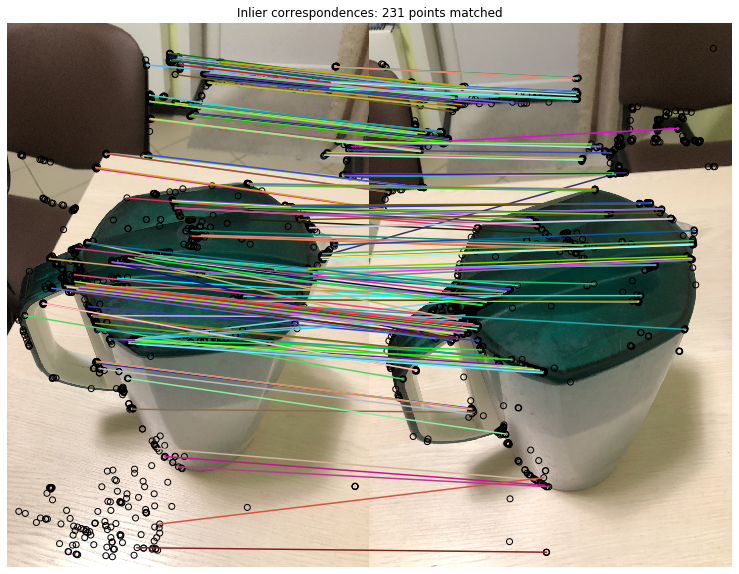

In [7]:
src, dest = pano_image_collection[0], pano_image_collection[1]

src_keypoints, src_descriptors = find_orb(src)
dest_keypoints, dest_descriptors = find_orb(dest)

robust_transform, matches = find_robust_transform(
    src_keypoints, src_descriptors, 
    dest_keypoints, dest_descriptors, 
    return_matches=True,
    model_class=DEFAULT_TRANSFORM, 
    min_samples=4, 
    residual_threshold=150, 
    max_trials=5000, 
)

plt.figure(figsize=FIGSIZE)
ax = plt.axes()
ax.axis("off")
ax.set_title(f"Inlier correspondences: {len(matches)} points matched")

plot_matches(
    ax, src, dest, 
    src_keypoints, 
    dest_keypoints, 
    matches
)

plt.show()

---

### CV tutorial path:

In [8]:
# IMAGES_DIR = '/home/ilyazaharkin/ilya_test_kettle'

# img1 = cv2.imread(f'{IMAGES_DIR}/1.jpg', 0)  # queryImage
# img2 = cv2.imread(f'{IMAGES_DIR}/2.jpg', 0)  # trainImage

# img1 = cv2.resize(img1, TARGET_SIZE)
# img2 = cv2.resize(img2, TARGET_SIZE)

# print(img1.shape)

# # Initiate SIFT/ORB/AKAZE detector
# n_keypoints = 2000
# orb = cv2.AKAZE_create()  # n_keypoints=n_keypoints

# # find the keypoints and descriptors with SIFT
# # orb.detect_and_extract(rgb2gray(img1).astype(np.float64))
# kp1, des1 = orb.detectAndCompute(img1, None)  # orb.keypoints, orb.descriptors
# # orb.detect_and_extract(rgb2gray(img2).astype(np.float64))
# kp2, des2 = orb.detectAndCompute(img2, None)  # orb.keypoints, orb.descriptors

# # BFMatcher with default params
# bf = cv2.BFMatcher()  # cv2.NORM_HAMMING, crossCheck=True
# # print(des1)
# # print(des2)
# matches = bf.knnMatch(des1, des2, k=2)

# kp1_ransac_format = np.array([kp1[i].pt for i in range(len(kp1))])
# kp2_ransac_format = np.array([kp2[i].pt for i in range(len(kp2))])
# matches_ransac_format = np.array([[
#     matches[i][j].queryIdx, matches[i][j].trainIdx] 
#     for i in range(len(matches)) 
#     for j in range(len(matches[i]))
# ])

# # RANSAC
# DEFAULT_TRANSFORM = ProjectiveTransform
# model, inliers = ransac(
#     (kp1_ransac_format[matches_ransac_format[:,0]], 
#      kp2_ransac_format[matches_ransac_format[:,1]]), 
#     model_class=DEFAULT_TRANSFORM, 
#     min_samples=4, 
#     residual_threshold=350, 
#     max_trials=5000, 
# )

# matches = [matches[i] for i in range(len(matches)) if inliers[i]]

# # Apply ratio test
# good = []
# for m,n in matches:
#     if m.distance < 0.75*n.distance:
#         good.append([m])

# # cv2.drawMatchesKnn expects list of lists as matches.
# img3 = None
# img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,outImg=img3,flags=2)

# plt.figure(figsize=FIGSIZE)
# plt.imshow(img3)
# plt.show();

---

# SFM example python implementation

In [107]:
!ls /home/ilyazaharkin/SFM_example/desk/

DSC02638.JPG  DSC02639.JPG  DSC02640.JPG  DSC02641.JPG	DSC02642.JPG


In [108]:
_img = plt.imread("/home/ilyazaharkin/SFM_example/desk/DSC02638.JPG")
ORIG_SIZE = (_img.shape[0], _img.shape[1])
ORIG_SIZE

(3648, 5472)

In [109]:
len(image_collection)

5

Target size:  (1368, 912)


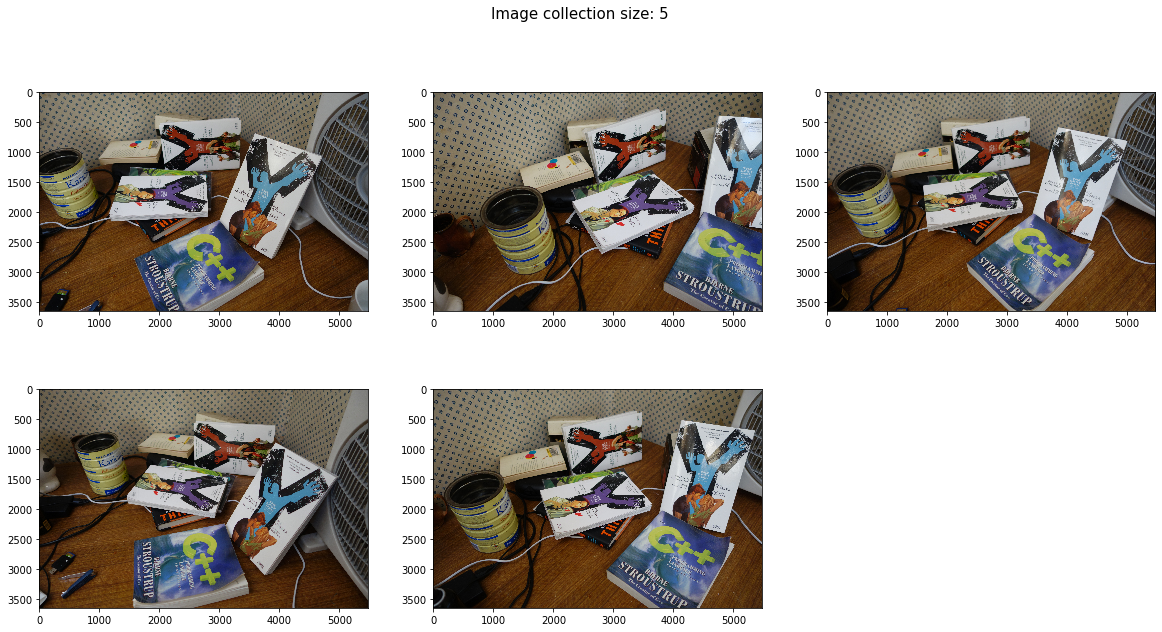

In [69]:
# downsample the image to speed up processing
SCALE_F = 4
# focal length in pixels, after downsampling, guess from jpeg EXIF data
FOCAL_LENGTH = 4308 / SCALE_F
# minimum number of camera views a 3d point (landmark) has to be seen to be used
MIN_LANDMARK_SEEN = 3

# MY DATA
# IMAGES_DIR = '/home/ilyazaharkin/ilya_test_kettle/'
# TARGET_SIZE = (720, 1080)

# DESK DATA
IMAGES_DIR = "/home/ilyazaharkin/SFM_example/desk/"
TARGET_SIZE = (ORIG_SIZE[1]//SCALE_F, ORIG_SIZE[0]//SCALE_F)  #(1080, 720)
print('Target size: ', TARGET_SIZE)

# image_collection = io.ImageCollection(
#     f'{IMAGES_DIR}/*.JPG',
#     load_func=lambda f: cv2.resize(
#         io.imread(f), TARGET_SIZE 
#     ).astype(np.float32) / 255
# )
image_collection_raw = [io.imread(filename) for filename in glob.glob(f'{IMAGES_DIR}/*.JPG')]
image_collection = [
    cv2.resize(x, TARGET_SIZE).astype(np.float64) / 255. 
    for x in image_collection_raw
]

cols = 3
rows = len(image_collection_raw) // cols + 1
fig = plt.figure(figsize=(20, 10))
fig.suptitle(f"Image collection size: {len(image_collection)}", fontsize=15)
for i,img in enumerate(image_collection_raw):
    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
plt.show();

In [126]:
class ImagePose():
    def __init__(self):
        self.img = np.empty(1)  # downsampled image used for display
        self.desc = np.empty(1)  # feature descriptor
        self.kp = []  # keypoints list consisting of cv::KeyPoint instances

        self.T = np.zeros((4,4))  # 4x4 pose transformation matrix
        self.P = np.zeros((3,4))  # 3x4 projection matrix

        self.kp_matches = defaultdict(int)  # keypoint matches in other images
        self.kp_landmark = defaultdict(int)  # seypoint to 3d points

    # helper methods
    def kp_match_exist(self, kp_idx, img_idx): 
        return self.kp_matches[(kp_idx, img_idx)] > 0
    
    def kp_3d_exist(self, kp_idx):
        return self.kp_landmark[kp_idx] != 0

    
# 3D point
class Landmark():
    def __init__(self):  
        self.pt = np.zeros((3))  # cv::Point3f
        self.seen = 0  # how many cameras have seen this point


class SFM_Helper():
    def __init__(self):
        self.img_pose = []  # consists of ImgPose class instances
        self.landmark = []  # consists of Lanmark class instances

In [127]:
SFM = SFM_Helper()

VIS = False

##############################   Find matching features   ############################

# Extract features
for i in range(len(image_collection)):
    a = ImagePose()
    a.img = cv2.resize(image_collection_raw[i], TARGET_SIZE)
    beg = time.time()
    img = image_collection[i]
    a.kp, a.desc = find_orb(img)
    print('ORB time:', time.time() - beg)
    SFM.img_pose.append(a)

# Match each image pair
for i in range(len(SFM.img_pose)):
    for j in range(i+1, len(SFM.img_pose)):
        # detect features and extract descriptors
        src_keypoints, src_descriptors = SFM.img_pose[i].kp, SFM.img_pose[i].desc
        dest_keypoints, dest_descriptors = SFM.img_pose[j].kp, SFM.img_pose[j].desc
        # RANSAC outlier filtering
        beg = time.time()
        robust_transform, matches = find_robust_transform(
            src_keypoints, src_descriptors, 
            dest_keypoints, dest_descriptors, 
            return_matches=True,
            model_class=DEFAULT_TRANSFORM, 
            min_samples=4, 
            residual_threshold=100, 
            max_trials=5000, 
        )
        print('Match and RANSAC time:', time.time() - beg)
        # save img1-kp1-img2-kp2 matches to global helper SFM instance
        for m in matches:
            SFM.img_pose[i].kp_matches[(m[0], j)] = m[1]
            SFM.img_pose[j].kp_matches[(m[1], i)] = m[0]
        print(f"Feature matching: image {i} <-> image {j} ==> {len(matches)} ")
        # vis
        if VIS:
            plt.figure(figsize=FIGSIZE)
            ax = plt.axes()
            ax.axis("off")
            ax.set_title(f"Inlier correspondences: {len(matches)} points matched")
            plot_matches(
                ax, 
                SFM.img_pose[i].img, 
                SFM.img_pose[j].img, 
                src_keypoints, 
                dest_keypoints, 
                matches
            )
            plt.show();

ORB time: 1.5623621940612793
ORB time: 1.5759713649749756
ORB time: 1.4710197448730469
ORB time: 1.5266284942626953
ORB time: 1.5958147048950195
Match and RANSAC time: 3.6618895530700684
Feature matching: image 0 <-> image 1 ==> 246 
Match and RANSAC time: 3.83384370803833
Feature matching: image 0 <-> image 2 ==> 717 
Match and RANSAC time: 3.876532793045044
Feature matching: image 0 <-> image 3 ==> 834 
Match and RANSAC time: 3.7714056968688965
Feature matching: image 0 <-> image 4 ==> 513 
Match and RANSAC time: 3.6627023220062256
Feature matching: image 1 <-> image 2 ==> 357 
Match and RANSAC time: 3.6381072998046875
Feature matching: image 1 <-> image 3 ==> 186 
Match and RANSAC time: 3.828723669052124
Feature matching: image 1 <-> image 4 ==> 631 
Match and RANSAC time: 3.752081871032715
Feature matching: image 2 <-> image 3 ==> 551 
Match and RANSAC time: 3.943321943283081
Feature matching: image 2 <-> image 4 ==> 677 
Match and RANSAC time: 3.6674559116363525
Feature matching: 

In [128]:
import pickle
# pickle.dump(SFM, open("SFM_temp.pkl", "wb"))

In [129]:
SFM = pickle.load(open("SFM_temp.pkl", "rb"))

In [130]:
def construct_intrinsic_matrix(focal_length, principal_point):
    K = np.eye(3)
    K[0,0] = K[1,1] = focal_length
    K[0,2] = principal_point[0]
    K[1,2] = principal_point[1]
    return K

def calculate_projection_matrix(R, t, prev_T, K):
    # local tansform
    T = np.eye(4)
    T[0:3, 0:3] = local_R
    T[0:3, 3:4] = local_t
    # accumulate transform
    T = prev_T @ T  # !!!
    # make projection matrix
    R = T[0:3, 0:3]
    t = T[0:3, 3:4]
    P = np.zeros((3, 4))
    P[0:3, 0:3] = R.T  # rotation
    P[0:3, 3:4] = -R.T @ t  # true translation
    P = K @ P  # projection = intrinsic x extrinsic
    return T, P

In [131]:
print(len(SFM.img_pose))
print(len(SFM.landmark))
for i in range(len(SFM.img_pose)):
    print(len(SFM.img_pose[i].kp_matches))
    print(len(SFM.img_pose[i].kp_landmark))

5
0
2310
0
1420
0
2302
0
1932
0
2182
0


In [132]:
##########################            Recover motion            ############################
##########################   between previous to current image   ###########################
##########################        and triangulate points       #############################

# Setup camera matrix
cx = SFM.img_pose[0].img.shape[1] / 2
cy = SFM.img_pose[0].img.shape[0] / 2

principal_point = (cx, cy)

K = construct_intrinsic_matrix(FOCAL_LENGTH, principal_point)
print(f"Initial intrinsic camera matrix K = \n{K}")

SFM.img_pose[0].T = np.eye(4)  # transformation (extrinsic) matrix
SFM.img_pose[0].P = K @ np.eye(3, 4)  # projection matrix

for i in range(len(SFM.img_pose)-1):
    prev = SFM.img_pose[i]
    cur = SFM.img_pose[i+1]

    # keypoints on this image that are matched with
    # other points after robust matching algo (see prev section: "Feature matching")
    kp_used = [
        k for k in range(len(prev.kp)) 
        if prev.kp_match_exist(k, i+1)
    ]
    src = np.array([prev.kp[k] for k in kp_used])
    dst = np.array([cur.kp[prev.kp_matches[(k, i+1)]] for k in kp_used])
    print(src.shape)
    print(dst.shape)
    
    # NOTE: pose from dst to src
    mask = np.empty(1)
    E, mask = cv2.findEssentialMat(
        dst, src, FOCAL_LENGTH, principal_point, cv2.FM_RANSAC, 0.999, 1.0, mask
    )  # OR cv2.findFundamentalMat()
#     mask_copy = mask.copy()  # !!!
    print('after findEssentialMat:', mask.sum())
    local_R, local_t = np.empty(1), np.empty(1)
    retval, local_R, local_t, mask = cv2.recoverPose(
        E, dst, src, local_R, local_t, FOCAL_LENGTH, principal_point, mask  # !!!
    )
    print('after recoverPose:', mask.sum())
    cur.T, cur.P = calculate_projection_matrix(local_R, local_t, prev.T, K)

    # calculate homogeneous coordinates of 3D points
    points4D = np.zeros((4, len(src)))
    points4D = cv2.triangulatePoints(prev.P, cur.P, src.T, dst.T, points4D)
    # отрисовать точки здесь !!!
    # ПОПРОБОВАТЬ СРАЗУ В GTSAM
    
    # Scale the new 3d points to be similar to the existing 3d points (landmark)
    # Use ratio of distance between pairing 3d points
    if i > 0:
        print('i =', i)
        new_pts = []  # list of Point3f
        existing_pts = []  # list of Point3f
        
        for j in range(len(kp_used)):
            k = kp_used[j]
            if mask[j][0] and prev.kp_match_exist(k, i+1) and prev.kp_3d_exist(k):
                # homogeneous coordinate to 3d point
                pt3d = points4D[:3, j] / points4D[3, j]
                # current landmark and corresponding predicted 3d point
                idx = prev.kp_landmark[k]
                avg_landmark = SFM.landmark[idx].pt / (SFM.landmark[idx].seen - 1)
                new_pts.append(pt3d)
                existing_pts.append(avg_landmark)
        
        # ratio of distance for all possible point pairing
        # probably an over kill! can probably just pick N random pairs
        new_pts = np.array(new_pts)
        existing_pts = np.array(existing_pts)
#         dist_new = scipy.spatial.distance.pdist(new_pts)
#         dist_existing = scipy.spatial.distance.pdist(existing_pts)
#         scale = np.mean(dist_existing / dist_new)
        scale = 0
        count = 0
        for j in range(len(new_pts)):  
            for k in range(j+1, len(new_pts)):
                norm_ex = np.linalg.norm(existing_pts[j] - existing_pts[k])
                norm_new = np.linalg.norm(new_pts[j] - new_pts[k])
                if norm_new == 0: continue  # !!!
                scale += norm_ex / norm_new
                count += 1
        scale /= count
        print(f'image {i+1} ==> {i} : scale={scale}, count={count}')

        # apply scale and re-calculate T and P matrix
        local_t *= scale
        cur.T, cur.P = calculate_projection_matrix(local_R, local_t, prev.T, K)
        points4D = cv2.triangulatePoints(prev.P, cur.P, src.T, dst.T, points4D)
        
    # Find good triangulated points
    for j in range(len(kp_used)):
        if mask[j][0]:
            k = kp_used[j]
            match_idx = prev.kp_matches[(k, i+1)]
            # homogeneous coordinate to 3d point
            pt3d = points4D[:3, j] / points4D[3, j]
            if prev.kp_3d_exist(k):
                # found a match with an existing landmark
                cur.kp_landmark[match_idx] = prev.kp_landmark[k]
                SFM.landmark[prev.kp_landmark[k]].pt += pt3d
                SFM.landmark[cur.kp_landmark[match_idx]].seen += 1
            else:
                # add new 3d point
                landmark = Landmark()
                landmark.pt = pt3d
                landmark.seen = 2
                SFM.landmark.append(landmark)
                prev.kp_landmark[k] = len(SFM.landmark) - 1
                cur.kp_landmark[match_idx] = len(SFM.landmark) - 1

# Average out the landmarks's 3d position
for l in SFM.landmark:
    if l.seen >= 3:
        l.pt /= l.seen - 1

Initial intrinsic camera matrix K = 
[[1.077e+03 0.000e+00 6.840e+02]
 [0.000e+00 1.077e+03 4.560e+02]
 [0.000e+00 0.000e+00 1.000e+00]]
(246, 2)
(246, 2)
after findEssentialMat: 153
after recoverPose: 153
(357, 2)
(357, 2)
after findEssentialMat: 269
after recoverPose: 269
i = 1
image 2 ==> 1 : scale=0.6359440814985511, count=2346
(551, 2)
(551, 2)
after findEssentialMat: 292
after recoverPose: 292
i = 2
image 3 ==> 2 : scale=0.9516973906803917, count=2016
(360, 2)
(360, 2)
after findEssentialMat: 204
after recoverPose: 204
i = 3
image 4 ==> 3 : scale=1.2471872999143414, count=2701


In [133]:
#############################    Run GTSAM bundle adjustment    ##############################

def symbol(name: str, index: int) -> int:
    """ helper for creating a symbol without explicitly casting 'name' from str to int """
    return gtsam.symbol(ord(name), index)

# skew is 0
K = Cal3_S2(FOCAL_LENGTH, FOCAL_LENGTH, 0, cx, cy)
# measurement_noise = noiseModel::Isotropic::Sigma(2, 2.0); // pixel error in (x,y)
measurement_noise = gtsam.noiseModel_Isotropic.Sigma(2, 2.0)  # one pixel in x and y
                
graph = NonlinearFactorGraph()

initial_estimate = Values()

# Poses
for i in range(len(SFM.img_pose)):
    img_pose = SFM.img_pose[i]

    R = Rot3(
        img_pose.T[0,0], img_pose.T[0,1], img_pose.T[0,2],
        img_pose.T[1,0], img_pose.T[1,1], img_pose.T[1,2],
        img_pose.T[2,0], img_pose.T[2,1], img_pose.T[2,2],
    )
    t = Point3(img_pose.T[0,3], img_pose.T[1,3], img_pose.T[2,3])
    pose = Pose3(R, t)

    # Add prior for the first image
    if i == 0:
        pose_noise = gtsam.noiseModel_Diagonal.Sigmas(np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))
        factor = PriorFactorPose3(symbol('x', 0), pose, pose_noise)  # add directly to graph
        graph.push_back(factor)

    initial_estimate.insert(symbol('x', i), pose)

    # landmark seen
    for k in range(len(img_pose.kp)):
        if img_pose.kp_3d_exist(k):
            landmark_id = img_pose.kp_landmark[k]
            if SFM.landmark[landmark_id].seen >= MIN_LANDMARK_SEEN:
                # measurement = camera.project(point) !!!
                # "pt" is "measurement", "j" is "landmark_id"
                pt = Point2(img_pose.kp[k][0], img_pose.kp[k][1])  # [0]==pt.x, [1]==pt.y
                # !!! СТОЛБЕЦ СТРОКА X Y ???
                factor = GenericProjectionFactorCal3_S2(
                    pt, measurement_noise, symbol('x', i), symbol('l', landmark_id), K)
                graph.push_back(factor)

# Add a prior on the calibration.
initial_estimate.insert(symbol('K', 0), K)

cal_noise = gtsam.noiseModel_Diagonal.Sigmas(np.array([100, 100, 0.01, 100, 100]))
factor = PriorFactorCal3_S2(symbol('K', 0), K, cal_noise)
graph.push_back(factor)

# Initialize estimate for landmarks
init_prior = False

for i in range(len(SFM.landmark)):
    if SFM.landmark[i].seen >= MIN_LANDMARK_SEEN:
        p = Point3(SFM.landmark[i].pt[0], SFM.landmark[i].pt[1], SFM.landmark[i].pt[2])
        initial_estimate.insert(symbol('l', i), p)
        if not init_prior:
            init_prior = True
            point_noise = gtsam.noiseModel_Isotropic.Sigma(3, 0.1)
            factor = PriorFactorPoint3(symbol('l', i), p, point_noise)
            graph.push_back(factor)
#             Point3 p = (SFM.landmark[i].pt[0], SFM.landmark[i].pt[1], SFM.landmark[i].pt[2])

graph.print_('Factor Graph:\n')
            
initial_estimate.print_('Initial Estimates:\n')
            
params = gtsam.LevenbergMarquardtParams()
params.setVerbosity('TERMINATION')
optimizer = LevenbergMarquardtOptimizer(graph, initial_estimate, params)

print('Optimizing:')
result = optimizer.optimize()

result.print_('Final results:\n')
print('initial error = {}'.format(graph.error(initial_estimate)))
print('final error = {}'.format(graph.error(result)))


Optimizing:
initial error = 14688.561327800664
final error = 59.26564515808606


In [134]:
import os
import shutil
import glob

In [105]:
############################    Create output files for PMVS2    #############################

def construct_proj_matrix_str(P):
    proj_matrix_str = ""
    for i in range(P.shape[0]):
        for j in range(P.shape[1]):
            proj_matrix_str += str(P[i][j])
            proj_matrix_str += " "
        proj_matrix_str += "\n"
    return proj_matrix_str

K_refined = result.atCal3_S2(symbol('K', 0)).matrix()
print(f"final camera matrix K:\n{K_refined}")

# Convert to full resolution camera matrix
K_refined[0, 0] *= SCALE_F
K_refined[1, 1] *= SCALE_F
K_refined[0, 2] *= SCALE_F
K_refined[1, 2] *= SCALE_F

print(f"final camera matrix K AFTER SCALING:\n{K_refined}")

PMVS_ROOT = "./root"

os.makedirs(f"{PMVS_ROOT}/visualize", exist_ok=True)
os.makedirs(f"{PMVS_ROOT}/txt", exist_ok=True)
os.makedirs(f"{PMVS_ROOT}/models", exist_ok=True)

options_filepath = f"{PMVS_ROOT}/options.txt"
with open(f"{options_filepath}", "w+") as options_file:
    options_file.write(f"timages  -1 0 {len(SFM.img_pose)-1}\n")
    options_file.write(f"oimages 0\n")
    options_file.write(f"level 1\n")
    
# IMAGES_DIR = "/home/ilyazaharkin/SFM_example/desk/"
IMAGES = [x.split('/')[-1] for x in glob.glob(f"{IMAGES_DIR}/*.JPG")]
print('IMAGES_DIR:', IMAGES_DIR)
print('IMAGES:', IMAGES)

for i in range(len(SFM.img_pose)):
    P = np.zeros((3, 4))

    R = result.atPose3(symbol('x', i)).rotation().matrix()
    t = result.atPose3(symbol('x', i)).translation().vector()
    
#     print(R)
#     print(t)

    P[0:3,0:3] = R.T
    P[:,3] = -R.T @ t
    P = K_refined @ P
    
#     print(P)

    src = f"{IMAGES_DIR}/{IMAGES[i]}"
    dest = f"{PMVS_ROOT}/visualize/{i:04}.jpg"
    shutil.copy(src, dest) 
    
    with open(f"{PMVS_ROOT}/txt/{i:04}.txt", "w+") as txt_curr_file:
        txt_curr_file.write("CONTOUR\n")
        proj_matrix_str = construct_proj_matrix_str(P)
        txt_curr_file.write(proj_matrix_str)

print(
    f"You can now run pmvs2 on the results e.g. \
    PATH_TO_PMVS_BINARY/pmvs2 {PMVS_ROOT} {PMVS_ROOT}/options.txt"
)

final camera matrix K:
[[1.077e+03 0.000e+00 6.840e+02]
 [0.000e+00 1.077e+03 4.560e+02]
 [0.000e+00 0.000e+00 1.000e+00]]
final camera matrix K AFTER SCALING:
[[4.308e+03 0.000e+00 2.736e+03]
 [0.000e+00 4.308e+03 1.824e+03]
 [0.000e+00 0.000e+00 1.000e+00]]
IMAGES_DIR: /home/ilyazaharkin/SFM_example/desk/
IMAGES: ['DSC02641.JPG', 'DSC02638.JPG', 'DSC02640.JPG', 'DSC02642.JPG', 'DSC02639.JPG']
You can now run pmvs2 on the results e.g.     PATH_TO_PMVS_BINARY/pmvs2 ./root ./root/options.txt


---

In [ ]:
int main(int argc, char **argv)
{
    SFM_Helper SFM;

    // Find matching features
    {
        using namespace cv;

        Ptr<AKAZE> feature = AKAZE::create();
        Ptr<DescriptorMatcher> matcher = DescriptorMatcher::create("BruteForce-Hamming");

        namedWindow("img", WINDOW_NORMAL);

        // Extract features
        for (auto f : IMAGES) {
            SFM_Helper::ImagePose a;

            Mat img = imread(IMAGE_DIR + f);
            assert(!img.empty());

            resize(img, img, img.size()/IMAGE_DOWNSAMPLE);
            a.img = img;
            cvtColor(img, img, COLOR_BGR2GRAY);

            feature->detect(img, a.kp);
            feature->compute(img, a.kp, a.desc);

            SFM.img_pose.emplace_back(a);
        }

        // Match features between all images
        for (size_t i=0; i < SFM.img_pose.size()-1; i++) {
            auto &img_pose_i = SFM.img_pose[i];
            for (size_t j=i+1; j < SFM.img_pose.size(); j++) {
                auto &img_pose_j = SFM.img_pose[j];
                vector<vector<DMatch>> matches;
                vector<Point2f> src, dst;
                vector<uchar> mask;
                vector<int> i_kp, j_kp;

                // 2 nearest neighbour match
                matcher->knnMatch(img_pose_i.desc, img_pose_j.desc, matches, 2);

                for (auto &m : matches) {
                    if(m[0].distance < 0.7*m[1].distance) {
                        src.push_back(img_pose_i.kp[m[0].queryIdx].pt);
                        dst.push_back(img_pose_j.kp[m[0].trainIdx].pt);

                        i_kp.push_back(m[0].queryIdx);
                        j_kp.push_back(m[0].trainIdx);
                    }
                }

                // Filter bad matches using fundamental matrix constraint
                findFundamentalMat(src, dst, FM_RANSAC, 3.0, 0.99, mask);

                Mat canvas = img_pose_i.img.clone();
                canvas.push_back(img_pose_j.img.clone());

                for (size_t k=0; k < mask.size(); k++) {
                    if (mask[k]) {
                        img_pose_i.kp_match_idx(i_kp[k], j) = j_kp[k];
                        img_pose_j.kp_match_idx(j_kp[k], i) = i_kp[k];

                        line(canvas, src[k], dst[k] + Point2f(0, img_pose_i.img.rows), Scalar(0, 0, 255), 2);
                    }
                }

                int good_matches = sum(mask)[0];
                assert(good_matches >= 10);

                cout << "Feature matching " << i << " " << j << " ==> " << good_matches << "/" << matches.size() << endl;

                resize(canvas, canvas, canvas.size()/2);

                imshow("img", canvas);
                waitKey(1);
            }
        }
    }

    // Recover motion between previous to current image and triangulate points
    {
        using namespace cv;

        // Setup camera matrix
        double cx = SFM.img_pose[0].img.size().width/2;
        double cy = SFM.img_pose[0].img.size().height/2;

        Point2d pp(cx, cy);

        Mat K = Mat::eye(3, 3, CV_64F);

        K.at<double>(0,0) = FOCAL_LENGTH;
        K.at<double>(1,1) = FOCAL_LENGTH;
        K.at<double>(0,2) = cx;
        K.at<double>(1,2) = cy;

        cout << endl << "initial camera matrix K " << endl << K << endl << endl;

        SFM.img_pose[0].T = Mat::eye(4, 4, CV_64F);
        SFM.img_pose[0].P = K*Mat::eye(3, 4, CV_64F);

        for (size_t i=0; i < SFM.img_pose.size() - 1; i++) {
            auto &prev = SFM.img_pose[i];
            auto &cur = SFM.img_pose[i+1];

            vector<Point2f> src, dst;
            vector<size_t> kp_used;

            for (size_t k=0; k < prev.kp.size(); k++) {
                if (prev.kp_match_exist(k, i+1)) {
                    size_t match_idx = prev.kp_match_idx(k, i+1);

                    src.push_back(prev.kp[k].pt);
                    dst.push_back(cur.kp[match_idx].pt);

                    kp_used.push_back(k);
                }
            }

            Mat mask;

            // NOTE: pose from dst to src
            Mat E = findEssentialMat(dst, src, FOCAL_LENGTH, pp, RANSAC, 0.999, 1.0, mask);
            Mat local_R, local_t;

            recoverPose(E, dst, src, local_R, local_t, FOCAL_LENGTH, pp, mask);

            // local tansform
            Mat T = Mat::eye(4, 4, CV_64F);
            local_R.copyTo(T(Range(0, 3), Range(0, 3)));
            local_t.copyTo(T(Range(0, 3), Range(3, 4)));

            // accumulate transform
            cur.T = prev.T*T;

            // make projection matrix
            Mat R = cur.T(Range(0, 3), Range(0, 3));
            Mat t = cur.T(Range(0, 3), Range(3, 4));

            Mat P(3, 4, CV_64F);

            P(Range(0, 3), Range(0, 3)) = R.t();
            P(Range(0, 3), Range(3, 4)) = -R.t()*t;
            P = K*P;

            cur.P = P;

            Mat points4D;
            triangulatePoints(prev.P, cur.P, src, dst, points4D);

            // Scale the new 3d points to be similar to the existing 3d points (landmark)
            // Use ratio of distance between pairing 3d points
            if (i > 0) {
                double scale = 0;
                int count = 0;

                Point3f prev_camera;

                prev_camera.x = prev.T.at<double>(0, 3);
                prev_camera.y = prev.T.at<double>(1, 3);
                prev_camera.z = prev.T.at<double>(2, 3);

                vector<Point3f> new_pts;
                vector<Point3f> existing_pts;

                for (size_t j=0; j < kp_used.size(); j++) {
                    size_t k = kp_used[j];
                    if (mask.at<uchar>(j) && prev.kp_match_exist(k, i+1) && prev.kp_3d_exist(k)) {
                        Point3f pt3d;

                        pt3d.x = points4D.at<float>(0, j) / points4D.at<float>(3, j);
                        pt3d.y = points4D.at<float>(1, j) / points4D.at<float>(3, j);
                        pt3d.z = points4D.at<float>(2, j) / points4D.at<float>(3, j);

                        size_t idx = prev.kp_3d(k);
                        Point3f avg_landmark = SFM.landmark[idx].pt / (SFM.landmark[idx].seen - 1);

                        new_pts.push_back(pt3d);
                        existing_pts.push_back(avg_landmark);
                    }
                }

                // ratio of distance for all possible point pairing
                // probably an over kill! can probably just pick N random pairs
                for (size_t j=0; j < new_pts.size()-1; j++) {
                    for (size_t k=j+1; k< new_pts.size(); k++) {
                        double s = norm(existing_pts[j] - existing_pts[k]) / norm(new_pts[j] - new_pts[k]);

                        scale += s;
                        count++;
                    }
                }

                assert(count > 0);

                scale /= count;

                cout << "image " << (i+1) << " ==> " << i << " scale=" << scale << " count=" << count <<  endl;

                // apply scale and re-calculate T and P matrix
                local_t *= scale;

                // local tansform
                Mat T = Mat::eye(4, 4, CV_64F);
                local_R.copyTo(T(Range(0, 3), Range(0, 3)));
                local_t.copyTo(T(Range(0, 3), Range(3, 4)));

                // accumulate transform
                cur.T = prev.T*T;

                // make projection ,matrix
                R = cur.T(Range(0, 3), Range(0, 3));
                t = cur.T(Range(0, 3), Range(3, 4));

                Mat P(3, 4, CV_64F);
                P(Range(0, 3), Range(0, 3)) = R.t();
                P(Range(0, 3), Range(3, 4)) = -R.t()*t;
                P = K*P;

                cur.P = P;

                triangulatePoints(prev.P, cur.P, src, dst, points4D);
            }

            // Find good triangulated points
            for (size_t j=0; j < kp_used.size(); j++) {
                if (mask.at<uchar>(j)) {
                    size_t k = kp_used[j];
                    size_t match_idx = prev.kp_match_idx(k, i+1);

                    Point3f pt3d;

                    pt3d.x = points4D.at<float>(0, j) / points4D.at<float>(3, j);
                    pt3d.y = points4D.at<float>(1, j) / points4D.at<float>(3, j);
                    pt3d.z = points4D.at<float>(2, j) / points4D.at<float>(3, j);

                    if (prev.kp_3d_exist(k)) {
                        // Found a match with an existing landmark
                        cur.kp_3d(match_idx) = prev.kp_3d(k);

                        SFM.landmark[prev.kp_3d(k)].pt += pt3d;
                        SFM.landmark[cur.kp_3d(match_idx)].seen++;
                    } else {
                        // Add new 3d point
                        SFM_Helper::Landmark landmark;

                        landmark.pt = pt3d;
                        landmark.seen = 2;

                        SFM.landmark.push_back(landmark);

                        prev.kp_3d(k) = SFM.landmark.size() - 1;
                        cur.kp_3d(match_idx) = SFM.landmark.size() - 1;
                    }
                }
            }
        }

        // Average out the landmark 3d position
        for (auto &l : SFM.landmark) {
            if (l.seen >= 3) {
                l.pt /= (l.seen - 1);
            }
        }
    }

    // Run GTSAM bundle adjustment
    gtsam::Values result;
    {
        using namespace gtsam;

        double cx = SFM.img_pose[0].img.size().width/2;
        double cy = SFM.img_pose[0].img.size().height/2;

        Cal3_S2 K(FOCAL_LENGTH, FOCAL_LENGTH, 0 /* skew */, cx, cy);
        noiseModel::Isotropic::shared_ptr measurement_noise = noiseModel::Isotropic::Sigma(2, 2.0); // pixel error in (x,y)

        NonlinearFactorGraph graph;
        Values initial;

        // Poses
        for (size_t i=0; i < SFM.img_pose.size(); i++) {
            auto &img_pose = SFM.img_pose[i];

            Rot3 R(
                img_pose.T.at<double>(0,0),
                img_pose.T.at<double>(0,1),
                img_pose.T.at<double>(0,2),

                img_pose.T.at<double>(1,0),
                img_pose.T.at<double>(1,1),
                img_pose.T.at<double>(1,2),

                img_pose.T.at<double>(2,0),
                img_pose.T.at<double>(2,1),
                img_pose.T.at<double>(2,2)
            );

            Point3 t;

            t(0) = img_pose.T.at<double>(0,3);
            t(1) = img_pose.T.at<double>(1,3);
            t(2) = img_pose.T.at<double>(2,3);

            Pose3 pose(R, t);

            // Add prior for the first image
            if (i == 0) {
                noiseModel::Diagonal::shared_ptr pose_noise = noiseModel::Diagonal::Sigmas((Vector(6) << Vector3::Constant(0.1), Vector3::Constant(0.1)).finished());
                graph.emplace_shared<PriorFactor<Pose3> >(Symbol('x', 0), pose, pose_noise); // add directly to graph
            }

            initial.insert(Symbol('x', i), pose);

            // landmark seen
            for (size_t k=0; k < img_pose.kp.size(); k++) {
                if (img_pose.kp_3d_exist(k)) {
                    size_t landmark_id = img_pose.kp_3d(k);

                    if (SFM.landmark[landmark_id].seen >= MIN_LANDMARK_SEEN) {
                        Point2 pt;

                        pt(0) = img_pose.kp[k].pt.x;
                        pt(1) = img_pose.kp[k].pt.y;

                        graph.emplace_shared<GeneralSFMFactor2<Cal3_S2>>(pt, measurement_noise, Symbol('x', i), Symbol('l', landmark_id), Symbol('K', 0));
                    }
                }
            }
        }

        // Add a prior on the calibration.
        initial.insert(Symbol('K', 0), K);

        noiseModel::Diagonal::shared_ptr cal_noise = noiseModel::Diagonal::Sigmas((Vector(5) << 100, 100, 0.01 /*skew*/, 100, 100).finished());
        graph.emplace_shared<PriorFactor<Cal3_S2>>(Symbol('K', 0), K, cal_noise);

        // Initialize estimate for landmarks
        bool init_prior = false;

        for (size_t i=0; i < SFM.landmark.size(); i++) {
            if (SFM.landmark[i].seen >= MIN_LANDMARK_SEEN) {
                cv::Point3f &p = SFM.landmark[i].pt;

                initial.insert<Point3>(Symbol('l', i), Point3(p.x, p.y, p.z));

                if (!init_prior) {
                    init_prior = true;

                    noiseModel::Isotropic::shared_ptr point_noise = noiseModel::Isotropic::Sigma(3, 0.1);
                    Point3 p(SFM.landmark[i].pt.x, SFM.landmark[i].pt.y, SFM.landmark[i].pt.z);
                    graph.emplace_shared<PriorFactor<Point3>>(Symbol('l', i), p, point_noise);
                }
            }
        }

        result = LevenbergMarquardtOptimizer(graph, initial).optimize();

        cout << endl;
        cout << "initial graph error = " << graph.error(initial) << endl;
        cout << "final graph error = " << graph.error(result) << endl;
    }

    // Create output files for PMVS2
    {
        using namespace gtsam;

        Matrix3 K_refined = result.at<Cal3_S2>(Symbol('K', 0)).K();

        cout << endl << "final camera matrix K" << endl << K_refined << endl;

        // Convert to full resolution camera matrix
        K_refined(0, 0) *= IMAGE_DOWNSAMPLE;
        K_refined(1, 1) *= IMAGE_DOWNSAMPLE;
        K_refined(0, 2) *= IMAGE_DOWNSAMPLE;
        K_refined(1, 2) *= IMAGE_DOWNSAMPLE;

        system("mkdir -p root/visualize");
        system("mkdir -p root/txt");
        system("mkdir -p root/models");

        ofstream option("root/options.txt");

        option << "timages  -1 " << 0 << " " << (SFM.img_pose.size()-1) << endl;;
        option << "oimages 0" << endl;
        option << "level 1" << endl;

        option.close();

        for (size_t i=0; i < SFM.img_pose.size(); i++) {
            Eigen::Matrix<double, 3, 3> R;
            Eigen::Matrix<double, 3, 1> t;
            Eigen::Matrix<double, 3, 4> P;
            char str[256];

            R = result.at<Pose3>(Symbol('x', i)).rotation().matrix();
            t = result.at<Pose3>(Symbol('x', i)).translation().vector();

            P.block(0, 0, 3, 3) = R.transpose();
            P.col(3) = -R.transpose()*t;
            P = K_refined*P;

            sprintf(str, "cp -f %s/%s root/visualize/%04d.jpg", IMAGE_DIR.c_str(), IMAGES[i].c_str(), (int)i);
            system(str);
            //imwrite(str, SFM.img_pose[i].img);

            with open(f"root/txt/{i}.txt")
            sprintf(str, , (int)i);
            ofstream out(str);

            out << "CONTOUR" << endl;

            for (int j=0; j < 3; j++) {
                for (int k=0; k < 4; k++) {
                    out << P(j, k) << " ";
                }
                out << endl;
            }
        }

        cout << endl;
        cout << "You can now run pmvs2 on the results eg. PATH_TO_PMVS_BINARY/pmvs2 root/ options.txt" << endl;
    }

	return 0;
}